Metro Census
============
This notebook gathers US census data from the American Community Survey (ACS) 5-year data set
and prepares it in straightforward data files for analysis, focusing on cities and metro
areas in the US.


In [1]:
from census import Census
import us
from us import states
import os
from types import SimpleNamespace
import pandas as pd
import geopandas as gpd
import requests

api_key = os.environ["CENSUS_API_KEY"]

In [2]:
# load tiger point data for all places in the us
tiger = gpd.read_file("../_data/tiger__points_places.geojson")
nyc_tracts = gpd.read_file("data/nyc_tracts.geojson")
nyc_tracts.head(5)

STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ NAME  \
0      36      081  003400  36081003400  1400000US36081003400   34   
1      36      081  003400  36081003400  1400000US36081003400   34   
2      36      081  003900  36081003900  1400000US36081003900   39   
3      36      081  003600  36081003600  1400000US36081003600   36   
4      36      081  003600  36081003600  1400000US36081003600   36   

          NAMELSAD  MTFCC FUNCSTAT   ALAND  AWATER     INTPTLAT      INTPTLON  \
0  Census Tract 34  G5020        S  213987       0  +40.6847731  -073.8581871   
1  Census Tract 34  G5020        S  213987       0  +40.6847731  -073.8581871   
2  Census Tract 39  G5020        S  146970       0  +40.7627994  -073.9409316   
3  Census Tract 36  G5020        S  180006       0  +40.6837714  -073.8568176   
4  Census Tract 36  G5020        S  180006       0  +40.6837714  -073.8568176   

   district           area         length  \
0        19  199876477.507  173935.429736   
1        27  790729699.933  572133.138809   
2        30  318135293.181  152856.203612   
3        19  199876477.507  173935.429736   
4        27  790729699.933  572133.138809   

                                            geometry  
0  POLYGON ((-73.86603 40.68192, -73.86607 40.682...  
1  POLYGON ((-73.86549 40.68342, -73.86533 40.683...  
2  POLYGON ((-73.94247 40.76199, -73.94139 40.763...  
3  POLYGON ((-73.86379 40.68111, -73.8641 40.6823...  
4  POLYGON ((-73.8637 40.68248, -73.86282 40.6827...

In [3]:
# get the metro area only, based on counties
us_counties = gpd.read_file("../_data/counties_500k.geojson")
# get NYC boroughs
# Bronx, Kings, Manhattan, Queens, Richmond
nyc_counties = ['36005', '36047', '36061', '36081', '36085']

# get shapes for NYC boroughs
boros = us_counties[us_counties['GEOID'].isin(nyc_counties)]

# join shapes for neighbors
neighbors = us_counties[us_counties.touches(boros.union_all())]
neighbors

# get the shapes for second degree neighbors
outer = us_counties[us_counties.touches(neighbors.union_all())]
metro = pd.concat([boros, neighbors, outer])
metro.drop_duplicates(subset='GEOID', inplace=True)
# metro.explore(tooltip="BASENAME")
metro.to_file("data/metro.geojson", driver="GeoJSON")
metro.head(5)

MTFCC             OID  GEOID STATE COUNTY  COUNTYNS  BASENAME  \
1401  G4020  27590311059161  36085    36    085  00974141  Richmond   
2333  G4020  27590307869814  36081    36    081  00974139    Queens   
2409  G4020  27590297862198  36047    36    047  00974122     Kings   
2446  G4020  27590460844234  36061    36    061  00974129  New York   
3164  G4020  27590287318864  36005    36    005  00974101     Bronx   

                 NAME LSADC FUNCSTAT COUNTYCC     AREALAND    AREAWATER  \
1401  Richmond County    06        C       H6  148982680.0  117441532.0   
2333    Queens County    06        C       H6  281594053.0  188444349.0   
2409     Kings County    06        C       H6  179684484.0   71158757.0   
2446  New York County    06        C       H6   58683879.0   29010416.0   
3164     Bronx County    06        C       H6  109235672.0   39353304.0   

      OBJECTID      CENTLAT       CENTLON     INTPTLAT      INTPTLON  \
1401      1402  +40.5807472  -074.1531284  +40.5612628  -074.1398995   
2333      2334  +40.7034162  -073.8195487  +40.6546581  -073.8412089   
2409      2410  +40.6412729  -073.9383407  +40.6350451  -073.9506398   
2446      2447  +40.7792209  -073.9668731  +40.7766419  -073.9701871   
3164      3165  +40.8500555  -073.8671639  +40.8487111  -073.8529390   

                                               geometry  
1401  MULTIPOLYGON (((-74.25563 40.50792, -74.25547 ...  
2333  MULTIPOLYGON (((-73.96262 40.73903, -73.96138 ...  
2409  MULTIPOLYGON (((-74.04171 40.62638, -74.04166 ...  
2446  MULTIPOLYGON (((-74.02307 40.72041, -74.02229 ...  
3164  MULTIPOLYGON (((-73.92982 40.88868, -73.92942 ...

<Axes: >

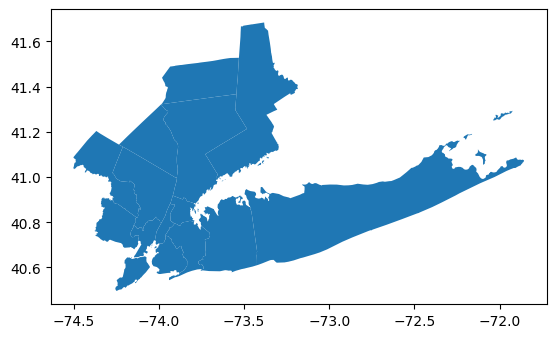

In [24]:
metro_places = tiger[tiger.within(metro.union_all())]
metro_places.head()
metro.plot()

In [5]:
tiger_zips = gpd.read_file( "../_data/tl_2023_us_zcta520/tl_2023_us_zcta520.shp")


In [22]:
metro_zips = tiger_zips[tiger_zips.intersects(metro_places.union_all())].copy()
metro_zips.rename(columns={"ZCTA5CE20": "zipcode"}, inplace=True)
# metro_zips.plot()
metro_zips.to_file("data/nyc-metro-zipcodes.geojson", driver="GeoJSON")

In [11]:
county_ids = list(metro.COUNTY)
state_fips = [states.NY.fips, states.NJ.fips, states.CT.fips, states.PA.fips]

demo_vars = {
           "NAME": "name",
         "COUNTY": "county",
    "B01003_001E": "total_pop",
    "B19013_001E": "median_inc",
    "B09001_001E": "population_under_18",
    "B17001_002E": "poverty",
    "B03002_006E": "asian",
    "B03002_004E": "black",
    "B03002_005E": "indian",
    "B03002_012E": "latino",
    "B03002_009E": "mixed",
    "B03002_008E": "other",
    "B03002_007E": "pacific",
    "B03002_003E": "white",
        "GEO_ID" :"geoid"
}


commute_vars = ['NAME', 'B08135_007M', 'B08135_003M', 'B08135_009M', 'B08135_004M', 'B08135_006M',
        'B08135_002M', 'B08135_010M', 'B08135_005M', 'B08135_008M', 'B08135_001M']

# print(f"county_ids = {county_ids}")
# print(f"demo_vars = {demo_vars.keys()}")
metro

MTFCC               OID  GEOID STATE COUNTY  COUNTYNS  \
1401  G4020    27590311059161  36085    36    085  00974141   
2333  G4020    27590307869814  36081    36    081  00974139   
2409  G4020    27590297862198  36047    36    047  00974122   
2446  G4020    27590460844234  36061    36    061  00974129   
3164  G4020    27590287318864  36005    36    005  00974101   
1013  G4020    27590303791235  36059    36    059  00974128   
1131  G4020    27590701443680  36119    36    119  00974157   
1341  G4020    27590460489405  34017    34    017  00882278   
2375  G4020    27590707071850  34003    34    003  00882271   
443   G4020    27590498683575  36103    36    103  00974149   
1400  G4020  2759030115366162  09190    09    190  02830254   
1518  G4020    27590696185754  36079    36    079  00974138   
2267  G4020    27590427877450  34013    34    013  00882276   
2668  G4020    27590427877451  34031    34    031  00882232   
2836  G4020    27590696995934  36087    36    087  00974142   

                 BASENAME                                 NAME LSADC FUNCSTAT  \
1401             Richmond                      Richmond County    06        C   
2333               Queens                        Queens County    06        C   
2409                Kings                         Kings County    06        C   
2446             New York                      New York County    06        C   
3164                Bronx                         Bronx County    06        C   
1013               Nassau                        Nassau County    06        A   
1131          Westchester                   Westchester County    06        A   
1341               Hudson                        Hudson County    06        A   
2375               Bergen                        Bergen County    06        A   
443               Suffolk                       Suffolk County    06        A   
1400  Western Connecticut  Western Connecticut Planning Region    PL        N   
1518               Putnam                        Putnam County    06        A   
2267                Essex                         Essex County    06        A   
2668              Passaic                       Passaic County    06        A   
2836             Rockland                      Rockland County    06        A   

     COUNTYCC      AREALAND     AREAWATER  OBJECTID      CENTLAT  \
1401       H6  1.489827e+08  1.174415e+08      1402  +40.5807472   
2333       H6  2.815941e+08  1.884443e+08      2334  +40.7034162   
2409       H6  1.796845e+08  7.115876e+07      2410  +40.6412729   
2446       H6  5.868388e+07  2.901042e+07      2447  +40.7792209   
3164       H6  1.092357e+08  3.935330e+07      3165  +40.8500555   
1013       H1  7.369606e+08  4.372907e+08      1014  +40.7325135   
1131       H1  1.115812e+09  1.793917e+08      1132  +41.1623763   
1341       H1  1.196408e+08  4.183649e+07      1342  +40.7408039   
2375       H1  6.029187e+08  3.538716e+07      2376  +40.9596009   
443        H1  2.359277e+09  3.787418e+09       444  +40.8685677   
1400       H5  1.378203e+09  3.001849e+08      1401  +41.3220899   
1518       H1  5.963501e+08  4.122963e+07      1519  +41.4267557   
2267       H1  3.265522e+08  8.653266e+06      2268  +40.7880196   
2668       H1  4.820820e+08  3.199785e+07      2669  +41.0342553   
2836       H1  4.498410e+08  6.691967e+07      2837  +41.1525017   

           CENTLON     INTPTLAT      INTPTLON  \
1401  -074.1531284  +40.5612628  -074.1398995   
2333  -073.8195487  +40.6546581  -073.8412089   
2409  -073.9383407  +40.6350451  -073.9506398   
2446  -073.9668731  +40.7766419  -073.9701871   
3164  -073.8671639  +40.8487111  -073.8529390   
1013  -073.5862222  +40.7296118  -073.5894144   
1131  -073.7562049  +41.1526862  -073.7457526   
1341  -074.0751167  +40.7313751  -074.0786014   
2375  -074.0741068  +40.9596985  -074.0747272   
443   -072.8465609  +40.9435540  -072.6922183   
1400  -073.4476768  +41.2790553  -073.4465497   
1518  -073.7495296  +41

In [13]:
vars = list(demo_vars.keys())
c = Census(api_key, year=2022)
nyc_counties = ['005', '047', '061', '081', '085']

data = []
for county in nyc_counties:
    county_data = c.acs5.get( vars, {'for': 'tract:*', 'in': f'state:{states.NY.fips} county:{county}'})
    data.extend(county_data)

data = pd.DataFrame(data)
data

NAME COUNTY  B01003_001E  \
0             Census Tract 1; Bronx County; New York    005       4446.0   
1             Census Tract 2; Bronx County; New York    005       4870.0   
2             Census Tract 4; Bronx County; New York    005       6257.0   
3            Census Tract 16; Bronx County; New York    005       6177.0   
4         Census Tract 19.01; Bronx County; New York    005       2181.0   
...                                              ...    ...          ...   
2322  Census Tract 303.02; Richmond County; New York    085       6374.0   
2323  Census Tract 319.01; Richmond County; New York    085       3674.0   
2324  Census Tract 319.02; Richmond County; New York    085       5053.0   
2325     Census Tract 323; Richmond County; New York    085       1133.0   
2326    Census Tract 9901; Richmond County; New York    085          0.0   

      B19013_001E  B09001_001E  B17001_002E  B03002_006E  B03002_004E  \
0    -666666666.0         58.0          0.0        123.0       2000.0   
1        115064.0        822.0        688.0        299.0       1281.0   
2        100553.0       1383.0        378.0        103.0       1559.0   
3         41362.0       1201.0        893.0        148.0       2132.0   
4         49500.0        475.0        623.0          0.0        942.0   
...           ...          ...          ...          ...          ...   
2322      98535.0       1120.0        893.0        918.0       1568.0   
2323      45942.0        860.0       1055.0        224.0       1626.0   
2324      75057.0       1646.0       1146.0        217.0       2388.0   
2325      88558.0        325.0         56.0         21.0        421.0   
2326 -666666666.0          0.0          0.0          0.0          0.0   

      B03002_005E  B03002_012E  B03002_009E  B03002_008E  B03002_007E  \
0             9.0       1172.0         30.0         14.0          0.0   
1             0.0       3109.0          0.0         98.0          0.0   
2             0.0       4212.0         36.0         64.0          0.0   
3           213.0       3507.0         66.0          5.0          0.0   
4            34.0        842.0         57.0          0.0          0.0   
...           ...          ...          ...          ...          ...   
2322          0.0       1625.0          0.0         54.0          0.0   
2323          0.0       1469.0         66.0          0.0          0.0   
2324          0.0       1913.0         62.0          0.0          0.0   
2325          0.0        394.0        188.0          0.0          0.0   
2326          0.0          0.0          0.0          0.0          0.0   

      B03002_003E                GEO_ID state county   tract  
0          1098.0  1400000US36005000100    36    005  000100  
1            83.0  1400000US36005000200    36    005  000200  
2           283.0  1400000US36005000400    36    005  000400  
3           106.0  1400000US36005001600    36    005  001600  
4           306.0  1400000US36005001901    36    005  001901  
...           ...                   ...   ...    ...     ...  
2322       2209.0  1400000US36085030302    36    085  030302  
2323        289.0  1400000US36085031901    36    085  031901  
2324        473.0  1400000US36085031902    36    085  031902  
2325        109.0  1400000US36085032300    36    085  032300  
2326          0.0  1400000US36085990100    36    085  990100  

[2327 rows x 18 columns]

In [14]:
demo_tracts = data.rename(columns=demo_vars)
nyc = nyc_tracts[["GEOIDFQ", "geometry"]].copy()

demo_tracts = nyc.merge(demo_tracts, left_on="GEOIDFQ", right_on="geoid", how="inner")
cols = ['name', 'total_pop', 'population_under_18', 'median_inc',
        'poverty', 'asian', 'black', 'latino', 'white', 'indian', 'pacific',
        'mixed', 'other', 'tract', 'state', 'geoid', 'geometry']

demo_tracts = demo_tracts[cols]
# demo_tracts.to_file("data/nyc_tracts_demographics.geojson", driver="GeoJSON")
demo_tracts

name  total_pop  \
0        Census Tract 34; Queens County; New York     2559.0   
1        Census Tract 34; Queens County; New York     2559.0   
2        Census Tract 39; Queens County; New York     1436.0   
3        Census Tract 36; Queens County; New York     4004.0   
4        Census Tract 36; Queens County; New York     4004.0   
...                                           ...        ...   
3039   Census Tract 1417; Queens County; New York     4877.0   
3040  Census Tract 62.02; Queens County; New York     6441.0   
3041  Census Tract 62.02; Queens County; New York     6441.0   
3042  Census Tract 169; New York County; New York     8010.0   
3043  Census Tract 164; New York County; New York     7814.0   

      population_under_18  median_inc  poverty   asian   black  latino  \
0                   457.0     79728.0    408.0   468.0    86.0  1628.0   
1                   457.0     79728.0    408.0   468.0    86.0  1628.0   
2                   226.0     53468.0    326.0   135.0    85.0   897.0   
3                  1022.0     86582.0    328.0  1273.0   140.0  2058.0   
4                  1022.0     86582.0    328.0  1273.0   140.0  2058.0   
...                   ...         ...      ...     ...     ...     ...   
3039                898.0     71303.0   1045.0  3061.0   120.0   512.0   
3040               1776.0     72061.0    641.0   504.0   321.0  2731.0   
3041               1776.0     72061.0    641.0   504.0   321.0  2731.0   
3042               1150.0    163500.0    598.0   696.0   159.0   783.0   
3043               1578.0     24789.0   3279.0   744.0  1734.0  4357.0   

       white  indian  pacific  mixed  other   tract state  \
0      258.0     7.0      0.0    4.0  108.0  003400    36   
1      258.0     7.0      0.0    4.0  108.0  003400    36   
2      273.0     0.0      0.0   46.0    0.0  003900    36   
3      382.0     0.0      0.0   82.0   69.0  003600    36   
4      382.0     0.0      0.0   82.0   69.0  003600    36   
...      ...     ...      ...    ...    ...     ...   ...   
3039  1042.0     0.0      0.0  116.0   26.0  141700    36   
3040  2403.0     0.0      0.0  469.0   13.0  006202    36   
3041  2403.0     0.0      0.0  469.0   13.0  006202    36   
3042  6291.0     0.0      0.0   24.0   57.0  016900    36   
3043   802.0     0.0      0.0  166.0   11.0  016400    36   

                     geoid                                           geometry  
0     1400000US36081003400  POLYGON ((-73.86603 40.68192, -73.86607 40.682...  
1     1400000US36081003400  POLYGON ((-73.86549 40.68342, -73.86533 40.683...  
2     1400000US36081003900  POLYGON ((-73.94247 40.76199, -73.94139 40.763...  
3     1400000US36081003600  POLYGON ((-73.86379 40.68111, -73.8641 40.6823...  
4     1400000US36081003600  POLYGON ((-73.8637 40.68248, -73.86282 40.6827...  
...                    ...                                                ...  
3039  1400000US36081141700  MULTIPOLYGON (((-73.79645 40.74986, -73.79605 ...  
3040  1400000US36081006202  MULTIPOLYGON (((-73.86174 40.65894, -73.86175 ...  
3041  1400000US36081006202  MULTIPOLYGON (((-73.86151 40.65905, -73.86122 ...  
3042  1400000US36061016900  POLYGON ((-73.97598 40.78637, -73.97551 40.787...  
3043  1400000US36061016400  POLYGON ((-73.947 40.78838, -73.94656 40.789, ...  

[3044 rows x 17 columns]

In [14]:
# demo_tracts[demo_tracts.median_inc > 0]
demo_tracts[demo_tracts.median_inc > 0].explore(tooltip="name", popup=['name', 'total_pop', 'population_under_18', 'median_inc',
        'poverty', 'asian', 'black', 'latino', 'white'], column='median_inc', cmap='Reds_r')

In [53]:
# join these places with our county geospacial data
df = zips.copy()
def mk_int(row):
    for k in row.keys():
        if k == "state": continue
        v = row[k]
        try:
            row[k] = int(v)
        except:
            pass
    return row
df = df.apply(mk_int, axis=1)
# df.rename(columns={"zip code tabulation area": "zipcode"}, inplace=True)
# df.drop(columns=["name", "county"], inplace=True)
df["zipcode"] = df["name"].apply(lambda x: x.replace("ZCTA5", "").strip())
df[["zipcode", "zip code tabulation area"]]

df = metro_zips.merge(df, on="zipcode")
df[df.median_inc > 0].explore( column="median_inc", tooltip="median_inc", cmap="viridis", legend=True)

In [77]:
places = metro_places[["NAME", "GEOIDFQ", "geometry"]].merge( df, left_on="GEOIDFQ", right_on="geoid", how="inner")
places.drop(columns=["geoid", "name", "GEOIDFQ", "place"], inplace=True)
places.rename(columns={"NAME": "name"}, inplace=True)
places["state"] = places["state"].apply(lambda x: us.states.lookup(x).abbr)
display(places.columns)
places = places[['name', 'total_pop', 'population_under_18', 'median_inc',
          'poverty', 'asian', 'black', 'indian', 'latino', 'mixed', 'other',
          'pacific', 'white', 'state', 'geometry']]
places.head()

Index(['name', 'geometry', 'total_pop', 'median_inc', 'population_under_18',
       'poverty', 'asian', 'black', 'indian', 'latino', 'mixed', 'other',
       'pacific', 'white', 'state'],
      dtype='object')

name  total_pop  population_under_18  median_inc  poverty  asian  \
0   Stamford     135413                25957      100718    13561   9406   
1    Danbury      86456                17560       79983     8795   4240   
2    Newtown       1959                  447      144375       44     39   
3    Norwalk      91050                17667       97879     9828   3615   
4  Ball Pond       2531                  819      138165      163     16   

   black  indian  latino  mixed  other  pacific  white state  \
0  24415     117   40385   3422    431       22  57215    CT   
1  10352      96   27435   4022   1646       17  38648    CT   
2     37       0     181     14      0        0   1688    CT   
3  15754      27   28000   2658    283       35  40678    CT   
4      0      11     321    152     55        0   1976    CT   

                     geometry  
0    POINT (-73.5498 41.0782)  
1  POINT (-73.47096 41.40143)  
2   POINT (-73.31195 41.4119)  
3  POINT (-73.41943 41.09296)  
4  POINT (-73.52683 41.46183)

In [80]:
places = gpd.sjoin( places, metro[["BASENAME", "geometry"]], how='left', predicate='within')
places.rename(columns={"BASENAME": "county"}, inplace=True)
places.drop(columns=["index_right"], inplace=True)
places.to_file("data/metro_places.geojson", driver="GeoJSON")
places

name  total_pop  population_under_18  median_inc  poverty  \
0            Stamford     135413                25957      100718    13561   
1             Danbury      86456                17560       79983     8795   
2             Newtown       1959                  447      144375       44   
3             Norwalk      91050                17667       97879     9828   
4           Ball Pond       2531                  819      138165      163   
..                ...        ...                  ...         ...      ...   
560        West Nyack       3768                  923      160020      103   
561     West Sayville       5032                  907      157275      185   
562  Wheatley Heights       5338                 1346      133125      315   
563         Wyandanch      13601                 3292       87669     2442   
564           Yaphank       6229                  939      116680      166   

     asian  black  indian  latino  mixed  other  pacific  white state  \
0     9406  24415     117   40385   3422    431       22  57215    CT   
1     4240  10352      96   27435   4022   1646       17  38648    CT   
2       39     37       0     181     14      0        0   1688    CT   
3     3615  15754      27   28000   2658    283       35  40678    CT   
4       16      0      11     321    152     55        0   1976    CT   
..     ...    ...     ...     ...    ...    ...      ...    ...   ...   
560    220    573       0     918      0      0        0   2057    NY   
561    106     48       0      34     59     26        0   4759    NY   
562    383   3053       0     599    150     23        0   1130    NY   
563     73   6817       7    5234    958    102        0    410    NY   
564     93    189       3     948     46     55        0   4895    NY   

                       geometry               county  
0      POINT (-73.5498 41.0782)  Western Connecticut  
1    POINT (-73.47096 41.40143)  Western Connecticut  
2     POINT (-73.31195 41.4119)  Western Connecticut  
3    POINT (-73.41943 41.09296)  Western Connecticut  
4    POINT (-73.52683 41.46183)  Western Connecticut  
..                          ...                  ...  
560  POINT (-73.97138 41.09069)             Rockland  
561  POINT (-73.10498 40.72946)              Suffolk  
562  POINT (-73.37056 40.76241)              Suffolk  
563  POINT (-73.36335 40.74956)              Suffolk  
564  POINT (-72.92328 40.83228)              Suffolk  

[565 rows x 16 columns]

In [23]:
df = df.sort_values(by="population", ascending=False)
cities = df[df.population > 100_000].copy()
cities.population = cities.population.astype(int)

cities["city"] = cities["name"].str.split(",", expand=True)[0].replace(" city", "", regex=True)
cities = cities[["city", "state", "population"]]
cities.to_csv("data/us-cities.csv", index=False)


KeyError: 'population'

In [43]:

a = tiger.GEOIDFQ.unique()
b = cities[cities.state.isin(tiger.STATE)].geoid.unique()
a = set(a)
b = set(b)
b.issubset(a)
geocities = cities.merge(tiger, left_on="geoid", right_on="GEOIDFQ", how="inner")
geocities = gpd.GeoDataFrame(geocities)
geocities["area"] = geocities.ALAND * 3.861e-7
geocities["geometry"] = geocities.apply(lambda row: Point(row.INTPTLON, row.INTPTLAT), axis=1)

geocities = geocities[['NAME', 'state', 'pop_2022',  'pop_2017', 'area', 'geometry']]
geocities.rename(columns={"NAME": "city", }, inplace=True)
geocities.explore()

In [46]:
geocities.sort_values("pop_2022", ascending=False, inplace=True)
geocities.to_file("data/city-points.geojson", driver="GeoJSON")


In [101]:
geocities = geocities[['NAME', 'state','pop_2022', 'pop_2021', 'pop_2018', 'area']]
geocities.rename(columns={"NAME": "name"}, inplace=True)

In [102]:
geocities.to_csv("data/large-us-cities.csv", index=False)

In [88]:
geocities.to_crs(epsg=3857, inplace=True)

# calculate the area of geocities
geocities["area"] = geocities.geometry.area
geocities["area"] = geocities["area"] * 3.861e-7
geocities[geocities.geoid == "1600000US3651000"].explore()

In [20]:
data[['OBJECTID', 'CTLabel', 'CT2020', 'BoroCT2020',
       'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 
       'Households - With Children', 'Median Household Income', 'tract',
       'county', 'name']]
income = pd.DataFrame(data.groupby("NTAName")["Median Household Income"].mean().sort_values(ascending=False)).reset_index()


NTAName  Median Household Income
0           Upper East Side-Carnegie Hill            189470.357143
1    Financial District-Battery Park City            183866.142857
2                    Tribeca-Civic Center            177522.600000
3                        Brooklyn Heights            154802.833333
4                       Greenwich Village            154185.428571
..                                    ...                      ...
196                           Brownsville             29075.428571
197                            West Farms             28815.200000
198                               Belmont             27838.714286
199                               Tremont             25699.666667
200                       Pelham Bay Park              2499.000000

[201 rows x 2 columns]

In [ ]:

folium.Choropleth(
    geo_data=data,
    data=data,  # Your data DataFrame
    name='Median Household Income',
    columns=['GEOID', 'Median Household Income'],  # Columns from your data
    key_on='feature.properties.GEOID',  # Key that links your data to the GeoJSON
    fill_color='YlGn',  # Color scheme, e.g., 'YlGn' for yellow-green
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Legend Title',
    popup="tract info"
).add_to(base_map)
base_map
